# Trait curiosity and pupil response

Pupil response was measured by an eye tracker (sampling rate 60HZ)
Trait curiosity was measured by two curiosity questionnaires. 

<video controls src="d2.m4v">animation</video>

In [1]:
pwd

'/Users/xiaoyunchen/Desktop/code/data'

In [ ]:
# import numpy, panda, scipy, matplotlib, pypillometry, pip intall pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

In [2]:
#global print for decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [20]:
# load dataset
pupil_df = pd.read_csv('Pupil_Adult.csv', sep=',', header=0)
pupil_df.head()

,unique_id,ID,Trial,Stimulus,Time,raw_pupil,Timestamp,Lpupil,Rpupil,Phase,MCI_Total,CEI_II_Total,MCI_Level,CEI_II_Level,interp_pupil,bc_pupil,smooth_interp_pupil
0,P01_1,P01,1,1_10fps.avi,0.000,3.037,19213,3.061,3.014,deblurring,53,32,Low,Low,3.037,0.006,2.862
1,P01_1,P01,1,1_10fps.avi,16.670,3.039,19230,3.030,3.049,deblurring,53,32,Low,Low,3.039,0.010,2.862
2,P01_1,P01,1,1_10fps.avi,33.340,3.022,19246,3.040,3.005,deblurring,53,32,Low,Low,3.022,0.011,2.862
3,P01_1,P01,1,1_10fps.avi,50.010,3.051,19263,3.071,3.031,deblurring,53,32,Low,Low,3.051,0.010,2.863
4,P01_1,P01,1,1_10fps.avi,66.680,3.061,19280,3.081,3.040,deblurring,53,32,Low,Low,3.061,0.011,2.863


## Drop column that is redundant - Timestamp

In [22]:
pupil_df01 = pupil_df.drop(pupil_df.columns[0], axis=1)
pupil_df01.head()

,ID,Trial,Stimulus,Time,raw_pupil,Timestamp,Lpupil,Rpupil,Phase,MCI_Total,CEI_II_Total,MCI_Level,CEI_II_Level,interp_pupil,bc_pupil,smooth_interp_pupil
0,P01,1,1_10fps.avi,0.000,3.037,19213,3.061,3.014,deblurring,53,32,Low,Low,3.037,0.006,2.862
1,P01,1,1_10fps.avi,16.670,3.039,19230,3.030,3.049,deblurring,53,32,Low,Low,3.039,0.010,2.862
2,P01,1,1_10fps.avi,33.340,3.022,19246,3.040,3.005,deblurring,53,32,Low,Low,3.022,0.011,2.862
3,P01,1,1_10fps.avi,50.010,3.051,19263,3.071,3.031,deblurring,53,32,Low,Low,3.051,0.010,2.863
4,P01,1,1_10fps.avi,66.680,3.061,19280,3.081,3.040,deblurring,53,32,Low,Low,3.061,0.011,2.863


## Data inspection: null values, descriptive statistics

In [23]:
#check for null value
print(pupil_df.isnull().sum())
#get descriptive statistics
print(pupil_df.describe(include='all'))

unique_id                   0
ID                          0
Trial                       0
Stimulus                    0
Time                        0
raw_pupil              101506
Timestamp                   0
Lpupil                      0
Rpupil                      0
Phase                       0
MCI_Total                   0
CEI_II_Total                0
MCI_Level                   0
CEI_II_Level                0
interp_pupil                0
bc_pupil                    0
smooth_interp_pupil         0
dtype: int64
       unique_id       ID       Trial     Stimulus        Time   raw_pupil  \
count    1311120  1311120 1311120.000      1311120 1311120.000 1209614.000   
unique      1821       42         NaN           50         NaN         NaN   
top        P01_1      P01         NaN  7_10fps.avi         NaN         NaN   
freq         720    36000         NaN        29520         NaN         NaN   
mean         NaN      NaN      24.832          NaN    5992.865       3.427   
std      

1. There were 42 participants who contributed to an average of 24.83 trials. 
1. The time for each trial lasted 9985 ms - about 10s.

## Distribution of Trait Curiosity - ideally should be evenly distributed

In [24]:
pupil_df['Count'] = 1
ID_agg = pupil_df.groupby(['ID','Trial'], as_index=False)['Count'].mean()
# top 10 participants who contributed the most trials
ID_top = ID_agg['Trial'].value_counts()[:10]
print(ID_top)
Trait_agg = pupil_df.groupby(['ID','MCI_Level'], as_index=False)['Count'].mean()
Trait_freq = Trait_agg['MCI_Level'].value_counts()
print(Trait_freq)

7     42
3     41
5     41
1     40
4     40
6     40
12    40
8     39
2     39
19    39
Name: Trial, dtype: int64
High    22
Low     20
Name: MCI_Level, dtype: int64


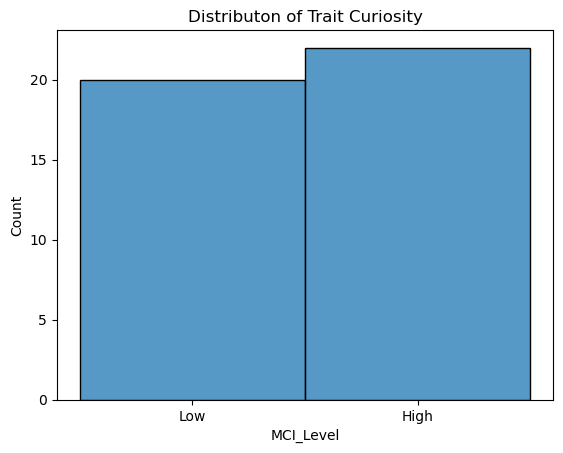

In [25]:
sns.histplot(data=Trait_agg, x='MCI_Level')
plt.title("Distributon of Trait Curiosity")
plt.show()

## Visualisation: Raw Pupil Response

<Axes: xlabel='Time', ylabel='raw_pupil'>

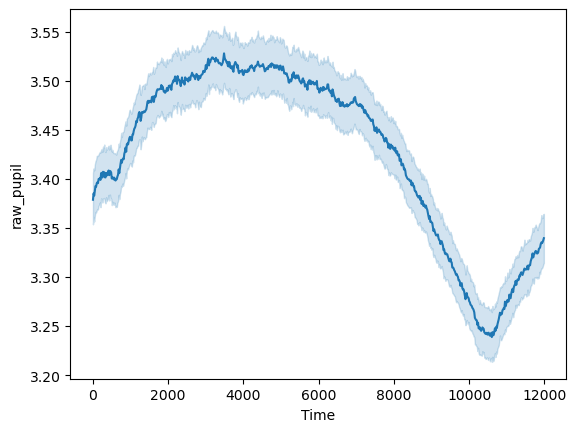

In [27]:
sns.lineplot(x = "Time", 
             y = "raw_pupil",
             data = pupil_df)

## Raw pupil response between high vs low curiosity

<Axes: xlabel='Time', ylabel='raw_pupil'>

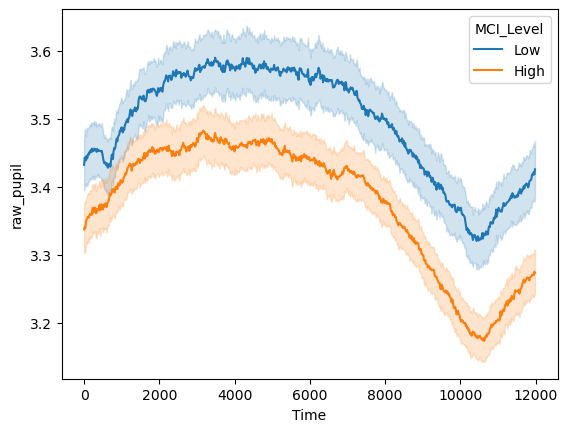

In [31]:
a = sns.lineplot( x = "Time", 
             y = "raw_pupil", 
             hue = "MCI_Level",
             data = pupil_df);
a

## smooth raw pupil reponse

In [ ]:
pupil_df["event"] = pupil_df["ID"].astype(str) + "_" + pupil_df["Trial"].astype(str)
pupil_df.head()

In [ ]:
# function to loop over each event for interpolation and smoothing
event = np.unique(pupil_df['event'])
empty_list = []

for i in event:
    sub =pupil_df[(pupil_df['event'] == i)]
    ts= pd.Series(sub['raw_pupil'], index=pupil_df['Time'])
    empty_list.append(ts)
    
pupil_df['new_pupil'] = empty_list

In [ ]:
## Visualisation smoothed response 

<Axes: xlabel='Time', ylabel='smooth_interp_pupil'>

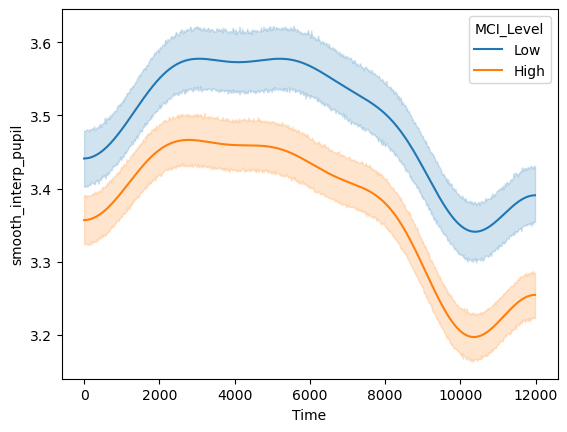

In [32]:
b = sns.lineplot( x = "Time", 
             y = "smooth_interp_pupil", 
             hue = "MCI_Level",
             data = pupil_df);
b

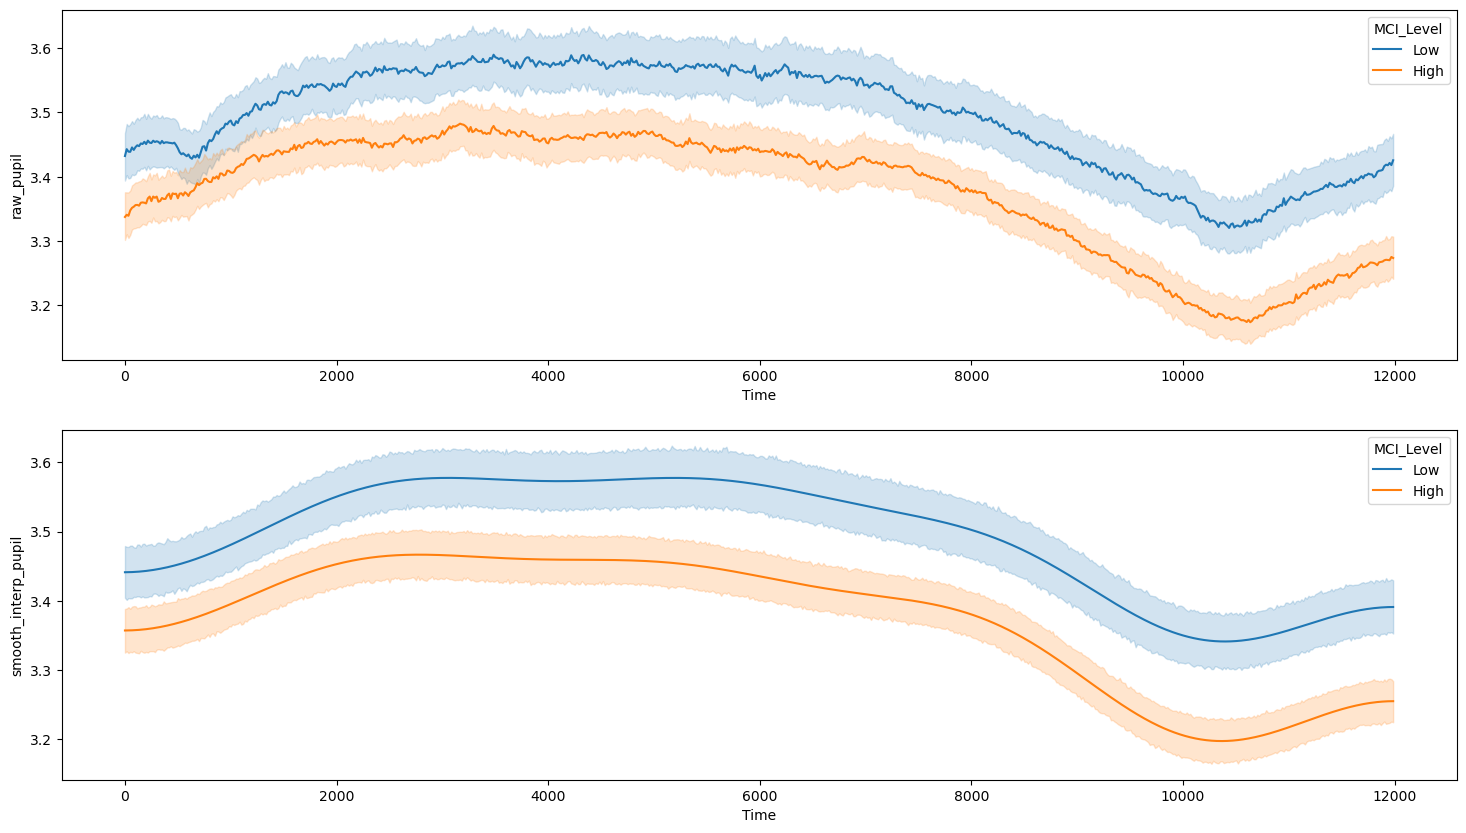

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
sns.lineplot(data=pupil_df, x = "Time", 
             y = "raw_pupil", 
             hue = "MCI_Level", ax=ax[0])
sns.lineplot(data=pupil_df, x = "Time", 
             y = "smooth_interp_pupil", 
             hue = "MCI_Level", ax=ax[1])
plt.show()